<a href="https://colab.research.google.com/github/jorgegzz1609-collab/AI_IB/blob/main/Assignments/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Final Project.- Training a Machine Learning model on medical images**
###Team:


2043501 - Jorge Alberto González Garza

1999159 - Julie Alejandra López Reyna

1993735 - Andrea Chavarría Hernández

2047928 - Juan Alejandro González Gómez

2049215 - Norma Cecilia Cazares del Angel

## **IMPORT DATABASE FROM KAGGLE**

We access to the database of brain-mri-images-for-braim-tumor-detection from Keaggle, we obtained the URL to get access and so we download the zip with the images.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jorgegonzlez1609","key":"e43c8887b8d705abe6e5b410fc19c0a6"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


## **SAVE DATABASE AS A .ZIP FILE IN GOOGLE DRIVE**

We save it into the directory in Google Colab environment, where we can have access to it, decompress it and work on it

In [4]:
import zipfile

zip_path = "/content/brain-mri-images-for-brain-tumor-detection.zip"
extract_path = "/content/medical_data"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)


## **LOAD IMAGES**

In this section, the load_images function is responsible for loading the images from the specified directories. For each image, it performs the following steps:

* Reads the image and converts it to grayscale.
* Resizes the image to a predefined size (128×128 pixels).
* Assigns a numerical label (0 for “no tumor” and 1 for “tumor”) based on the name of the folder where the image is located.

Finally, it returns the images as a NumPy array along with their corresponding labels, ready to be processed and used in the model.

In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_images(path, size=(128,128)):
    X, y = [], []
    categories = {"no":0, "yes":1}

    for label in categories:
        folder = os.path.join(path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv2.resize(img, size)
            X.append(img)
            y.append(categories[label])

    return np.array(X), np.array(y)


## **PROCESS AND NORMALIZATION OF IMAGES**

In this part, the following steps are performed:

* Normalization: The pixel values of the images are converted to float32 and divided by 255.0. This scales the pixel values from 0–255 to 0–1, which is a common practice to improve the performance and stability of neural network training.
* Reshape: The images are reshaped to the form (-1, 128, 128, 1). The -1 allows NumPy to automatically determine the number of images, while 128 × 128 represents the height and width, and 1 indicates that the images are in grayscale (a single channel).
* One-Hot Encoding of Labels: The numerical labels are converted into a one-hot encoded format using to_categorical. This is necessary for classification problems, where each label is represented as a binary vector.

In [6]:
data_dir = "/content/medical_data/brain_tumor_dataset"
images, labels = load_images(data_dir)

# Normalizar
images = images.astype("float32") / 255.0
images = images.reshape(-1,128,128,1)

labels_cat = to_categorical(labels)


## **TRAIN–TEST SPLIT**



The original dataset is divided into 80% for training and 20% for testing. A random state of 7 is assigned to ensure that the same training and testing sets are used if the neural network model is run again.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_cat, test_size=0.20, random_state=7
)


## **BUILDING THE CONVOLUTIONAL NEURAL NETWORK (CNN)**


In this section, the architecture of the neural network model is defined. This includes:


Convolutional Layers (Conv2D): Used to extract features from the images by applying filters that detect patterns. Multiple layers with an increasing number of filters (16, 32, 64) are used to capture features at different levels of complexity.

* Pooling Layers (MaxPooling2D): These reduce the dimensionality of the feature maps, helping make the model more efficient and preventing overfitting.
* Flatten: Converts the output of the convolutional layers into a one-dimensional vector.
* Dense Layers (Dense): Traditional neural network layers that perform the final classification.
* Dropout: A Dropout layer is used for regularization, randomly deactivating a percentage of neurons during training to prevent overfitting.
* Model Compilation: Finally, the model is compiled by specifying the optimizer ('adam'), the loss function, and the metrics to evaluate ('accuracy').


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,306 (3.15 MB)

 Trainable params: 826,306 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

## **MAKING PREDICTIONS WITH THE CNN**


The previously defined model is trained using the training data (X_train and y_train). This training process is performed for a specific number of epochs (in this case, 12), during which the model adjusts its internal weights to improve accuracy. During training, 15% of the training data is set aside as a validation set, allowing the model’s performance on unseen data to be monitored after each epoch and helping detect potential overfitting.

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=12,
    validation_split=0.15,
    batch_size=32
)


Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.6495 - loss: 0.6299 - val_accuracy: 0.8065 - val_loss: 0.5395
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.8152 - loss: 0.4780 - val_accuracy: 0.8387 - val_loss: 0.4458
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.7662 - loss: 0.5126 - val_accuracy: 0.8387 - val_loss: 0.4647
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.8084 - loss: 0.4491 - val_accuracy: 0.7742 - val_loss: 0.5476
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.8226 - loss: 0.4191 - val_accuracy: 0.8710 - val_loss: 0.3901
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.8568 - loss: 0.3548 - val_accuracy: 0.8387 - val_loss: 0.4842
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8644 - loss: 0.3432 - val_accuracy: 0.9032 - val_loss: 0.3248
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9025 - loss: 0.2911 - val_accuracy: 0.8065 - val_loss:

## **TRAIN VS VALIDATION ACCURACY GRAPH**



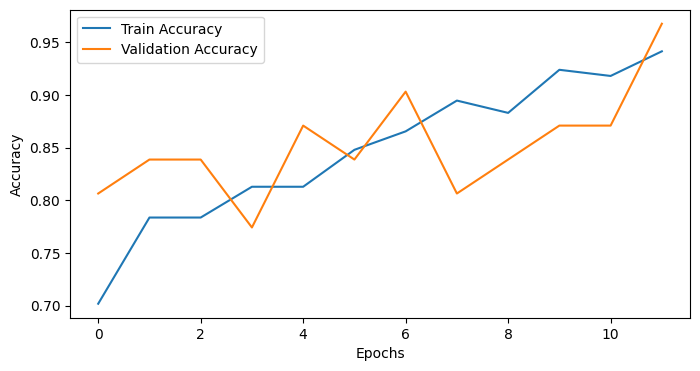

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **SAMPLING 10 PREDICTIONS**

The images from the test set (X_test) are used for the trained model to generate its predictions. Then, the first ten of these test images are displayed. For each image, the grayscale image is shown and the model’s prediction is compared with the true label. The title indicates the prediction (‘P’) and the true label (‘T’), and it is colored blue if the prediction is correct or red if it is incorrect, allowing for a quick visual inspection of the model’s performance.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


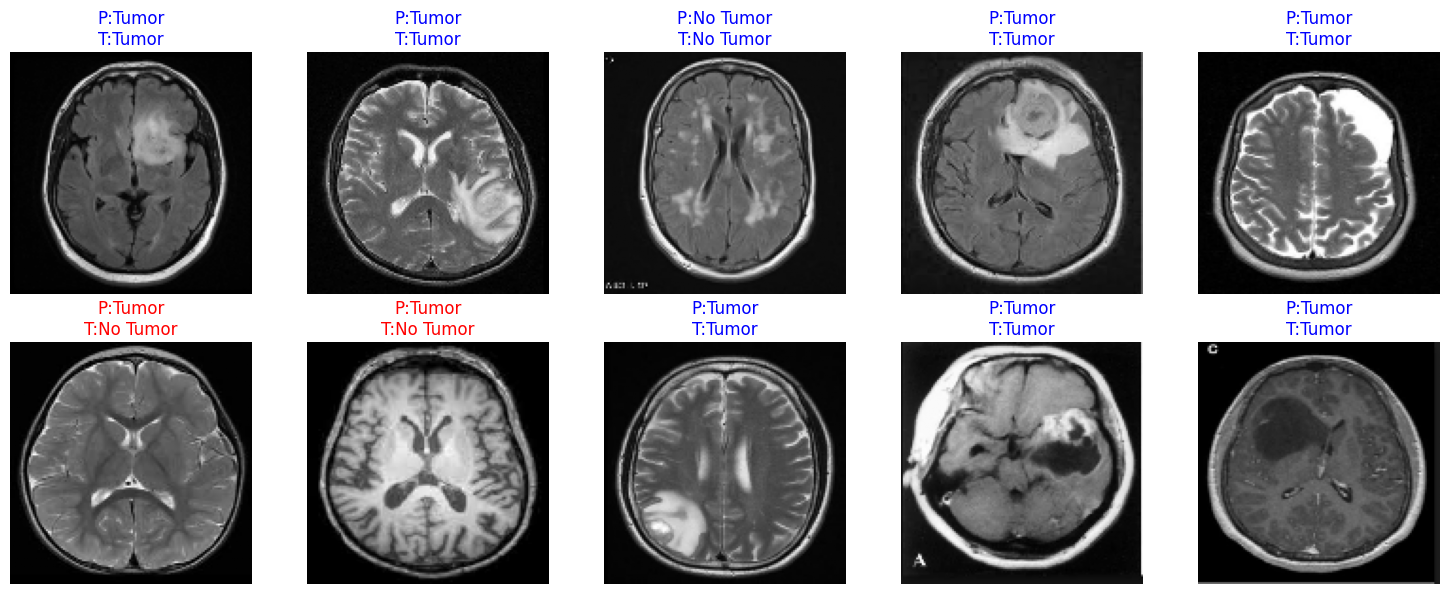

In [11]:
pred = model.predict(X_test)
class_names = ["No Tumor", "Tumor"]

plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i].reshape(128,128), cmap="gray")
    plt.axis("off")

    p = np.argmax(pred[i])
    t = np.argmax(y_test[i])

    color = "blue" if p == t else "red"
    plt.title(f"P:{class_names[p]}\nT:{class_names[t]}", color=color)

plt.tight_layout()
plt.show()
